In [3]:
import tensorflow
from tensorflow import keras

import numpy as np
import threading
import statistics
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, normalize

# 1. Loading & Observing Data

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

N = 25000
x_train = x_train[:N]
y_train = y_train[:N]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
(25000, 32, 32, 3) (25000, 1)
(10000, 32, 32, 3) (10000, 1)


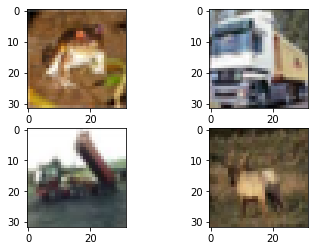

In [10]:
for i in range(4):
    plt.subplot(221+i)
    plt.imshow(x_train[i]);

In [8]:
enc = LabelEncoder()
y_train_binary = enc.fit_transform(y_train.reshape(-1,1))
y_test_binary = enc.fit_transform(y_test.reshape(-1,1))

enc = OneHotEncoder()
y_train_binary = enc.fit_transform(y_train_binary.reshape(-1,1))
y_test_binary = enc.fit_transform(y_test_binary.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
y_train_binary = y_train_binary.toarray()
y_test_binary = y_test_binary.toarray()

# 2-3. CNN. Training & Evaluation

In [13]:
def make_tiny_vgg(verbose, losses=[], accs=[]):
    keras.backend.clear_session()

    input_2 = keras.layers.Input(x_train.shape[1:])
    conv2d_4 = keras.layers.Conv2D(10, kernel_size=(3,3), padding='same')(input_2)
    activation_4 = keras.layers.Activation('relu')(conv2d_4)
    conv2d_5 = keras.layers.Conv2D(10, kernel_size=(3,3), padding='same')(activation_4)
    activation_5 = keras.layers.Activation('relu')(conv2d_5)
    max_pooling2d_2 = keras.layers.MaxPooling2D((2,2))(activation_5)
    conv2d_6 = keras.layers.Conv2D(10, kernel_size=(3,3), padding='same')(max_pooling2d_2)
    activation_6 = keras.layers.Activation('relu')(conv2d_6)
    conv2d_7 = keras.layers.Conv2D(10, kernel_size=(3,3), padding='same')(activation_6)
    activation_7 = keras.layers.Activation('relu')(conv2d_7)
    max_pooling2d_3 = keras.layers.MaxPooling2D((2,2))(activation_7)
    flatten_1 = keras.layers.Flatten()(max_pooling2d_3)
    dense_1 = keras.layers.Dense(10, activation='softmax')(flatten_1)

    vgg_tiny = keras.models.Model(inputs=input_2, outputs=dense_1, name='tiny_vgg')
    if verbose:
        vgg_tiny.summary()
    vgg_tiny.compile(optimizer=keras.optimizers.Adam(),
                    loss=keras.losses.categorical_crossentropy,
                    metrics=['accuracy'])
    
    hist = vgg_tiny.fit(x_train, y_train_binary, batch_size=128,
                   epochs=100, validation_split=0.3, verbose=verbose,
                   callbacks=[keras.callbacks.EarlyStopping(patience=10)])
    
    if verbose:
        loss, acc = vgg_tiny.evaluate(x_train, y_train_binary)
        print(f'train loss: {loss}\ntrain acc: {acc}')
    
    loss, acc = vgg_tiny.evaluate(x_test, y_test_binary)
    losses.append(loss)
    accs.append(acc)
    
    if verbose:
        print(f'test loss: {loss}\ntest acc: {acc}')
        
        # plot results
        plt.figure(111)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.plot(hist.history['loss'], c='blue', label='training loss')
        plt.plot(hist.history['val_loss'], c='red', label='validation loss')

        plt.figure(112)
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.plot(hist.history['accuracy'], c='blue', label='training acc')
        plt.plot(hist.history['val_accuracy'], c='red', label='validation acc')
        plt.legend();
    
    return vgg_tiny

Model: "tiny_vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 10)        280       
                                                                 
 activation (Activation)     (None, 32, 32, 10)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 10)        910       
                                                                 
 activation_1 (Activation)   (None, 32, 32, 10)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 10)       0         
 )                                                               
                                                          

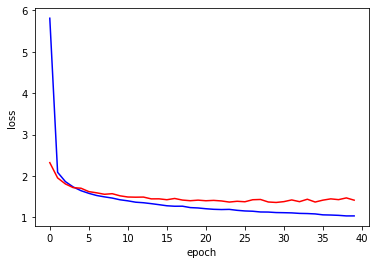

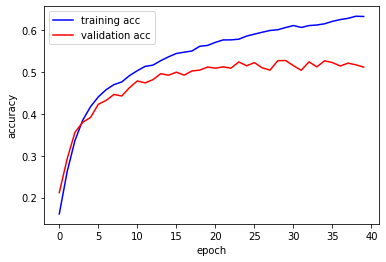

In [14]:
vgg_tiny = make_tiny_vgg(True)

In [15]:
losses, accs = [], []
threads = [threading.Thread(target=make_tiny_vgg, args=(False, losses, accs)) for i in range(5)]
for thread in threads:
  thread.start()
  thread.join()

313/313 [==============================] - 1s 4ms/step - loss: 1.4089 - accuracy: 0.5136


No handles with labels found to put in legend.


[loss] mean: 1.4198471069335938, std: 0.027049480352132914
[accuracy] mean: 0.5208599925041199, std: 0.008843243531035326


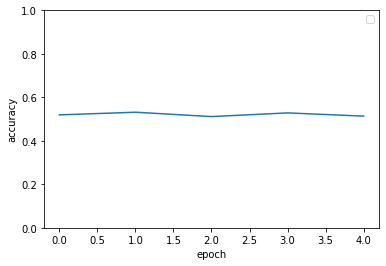

In [20]:
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.plot(accs)
plt.legend();

print(f'[loss] mean: {np.mean(losses)}, std: {statistics.stdev(losses)}')
print(f'[accuracy] mean: {np.mean(accs)}, std: {statistics.stdev(accs)}')

# 4. Visualization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


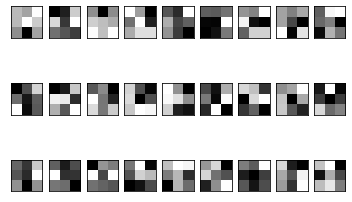

In [17]:
for layer in vgg_tiny.layers:
  if 'conv' not in layer.name:
    continue

  filters, biases = vgg_tiny.layers[1].get_weights()
  f_min, f_max = filters.min(), filters.max()
  filters = (filters - f_min) / (f_max - f_min)
  n_filters, ix = 9, 1

  for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
      # specify subplot and turn of axis
      ax = plt.subplot(3, 3*3, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      # plot filter channel in grayscale
      plt.imshow(f[:, :, j], cmap='gray')
      ix += 1
# show the figure
plt.show()

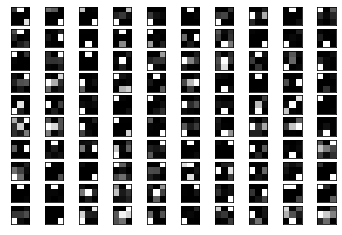

In [42]:
feature_maps = vgg_tiny.predict(x_test)

square = 10
ix = 1
for _ in range(square):
  for _ in range(square):
    ax = plt.subplot(square, square, ix)
    ax.set_xticks([])
    ax.set_yticks([])

    # plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
    plt.imshow(feature_maps[ix][:-1].reshape(3,3), cmap='gray')
    ix += 1
# show the figure
plt.show()

102981632/102967424 [==============================] - 1s 0us/step


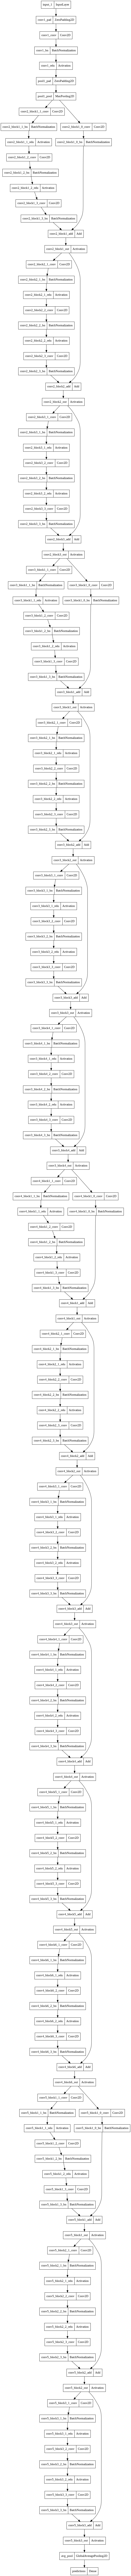

In [43]:
resnet50 = keras.applications.ResNet50()
keras.utils.plot_model(resnet50)

# 5. Improving the model

In [5]:
def make_tiny_vgg2(verbose, losses=[], accs=[]):
    keras.backend.clear_session()

    input_2 = keras.layers.Input(x_train.shape[1:])
    conv2d_4 = keras.layers.Conv2D(10, kernel_size=(3,3), padding='same')(input_2)
    batch_1 = keras.layers.BatchNormalization()(conv2d_4)
    activation_4 = keras.layers.Activation('relu')(batch_1)
    conv2d_5 = keras.layers.Conv2D(10, kernel_size=(3,3), padding='same')(activation_4)
    batch_2 = keras.layers.BatchNormalization()(conv2d_5)
    activation_5 = keras.layers.Activation('relu')(batch_2)
    max_pooling2d_2 = keras.layers.MaxPooling2D((2,2))(activation_5)
    conv2d_6 = keras.layers.Conv2D(10, kernel_size=(3,3), padding='same')(max_pooling2d_2)
    batch_3 = keras.layers.BatchNormalization()(conv2d_6)
    activation_6 = keras.layers.Activation('relu')(batch_3)
    conv2d_7 = keras.layers.Conv2D(10, kernel_size=(3,3), padding='same')(activation_6)
    batch_4 = keras.layers.BatchNormalization()(conv2d_7)
    activation_7 = keras.layers.Activation('relu')(batch_4)
    max_pooling2d_3 = keras.layers.MaxPooling2D((2,2))(activation_7)
    flatten_1 = keras.layers.Flatten()(max_pooling2d_3)
    dense_1 = keras.layers.Dense(10, activation='softmax')(flatten_1)

    vgg_tiny = keras.models.Model(inputs=input_2, outputs=dense_1, name='tiny_vgg')
    if verbose:
        vgg_tiny.summary()
    vgg_tiny.compile(optimizer=keras.optimizers.Adam(),
                    loss=keras.losses.categorical_crossentropy,
                    metrics=['accuracy'])
    
    hist = vgg_tiny.fit(x_train, y_train_binary, batch_size=128,
                   epochs=3, validation_split=0.3, verbose=verbose,
                   callbacks=[keras.callbacks.EarlyStopping(patience=10)])
    
    if verbose:
        loss, acc = vgg_tiny.evaluate(x_train, y_train_binary)
        print(f'train loss: {loss}\ntrain acc: {acc}')
    
    loss, acc = vgg_tiny.evaluate(x_test, y_test_binary)
    losses.append(loss)
    accs.append(acc)
    
    if verbose:
        print(f'test loss: {loss}\ntest acc: {acc}')
        
        # plot results
        plt.figure(111)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.plot(hist.history['loss'], c='blue', label='training loss')
        plt.plot(hist.history['val_loss'], c='red', label='validation loss')

        plt.figure(112)
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.plot(hist.history['accuracy'], c='blue', label='training acc')
        plt.plot(hist.history['val_accuracy'], c='red', label='validation acc')
        plt.legend();
    
    return vgg_tiny

Model: "tiny_vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 10)        280       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 10)       40        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 10)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 10)        910       
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 10)       40        
 hNormalization)                                          

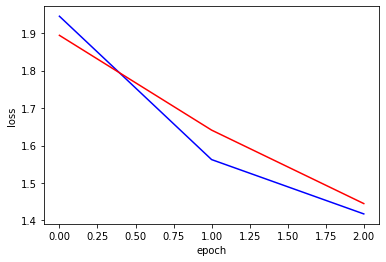

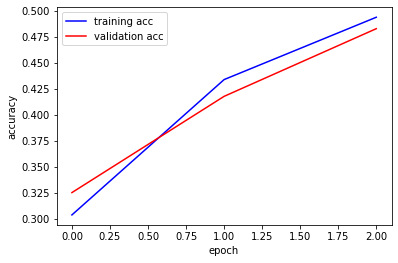

In [47]:
vgg_tiny2 = make_tiny_vgg2(True)

In [10]:
losses, accs = [], []
threads = [threading.Thread(target=make_tiny_vgg2, args=(False, losses, accs)) for i in range(5)]
for thread in threads:
  thread.start()
  thread.join()

313/313 [==============================] - 1s 4ms/step - loss: 1.3895 - accuracy: 0.5043


No handles with labels found to put in legend.


[loss] mean: 1.4353851795196533, std: 0.043671080826994176
[accuracy] mean: 0.48317999839782716, std: 0.018586747357704103


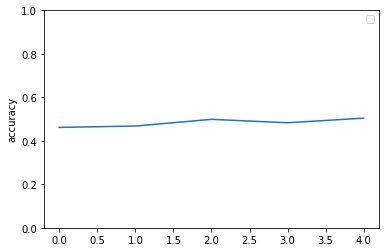

In [12]:
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.plot(accs)
plt.legend();

print(f'[loss] mean: {np.mean(losses)}, std: {statistics.stdev(losses)}')
print(f'[accuracy] mean: {np.mean(accs)}, std: {statistics.stdev(accs)}')

# Bonus

In [44]:
def make_tiny_vgg3(verbose, losses=[], accs=[]):
    keras.backend.clear_session()

    input_2 = keras.layers.Input(x_train.shape[1:])

    conv_1 = keras.layers.Conv2D(10, kernel_size=(7,7), padding='same')(input_2)
    batch_11 = keras.layers.BatchNormalization()(conv_1)
    max_pooling_1 = keras.layers.MaxPooling2D((2,2))(batch_11)
    activ_1 = keras.layers.Activation('relu')(max_pooling_1)

    conv2d_4 = keras.layers.Conv2D(10, kernel_size=(3,3), padding='same')(activ_1)
    batch_1 = keras.layers.BatchNormalization()(conv2d_4)

    add_2 = keras.layers.Add()([activ_1, batch_1])
    activation_4 = keras.layers.Activation('relu')(add_2)

    conv_2 = keras.layers.Conv2D(10, kernel_size=(7,7), padding='same')(activation_4)
    batch_12 = keras.layers.BatchNormalization()(conv_2)
    # max_pooling_2 = keras.layers.MaxPooling2D((2,2))(batch_12)

    add_3 = keras.layers.Add()([activation_4, batch_12])
    activ_2 = keras.layers.Activation('relu')(add_3)

    conv2d_5 = keras.layers.Conv2D(10, kernel_size=(3,3), padding='same')(activ_2)
    batch_2 = keras.layers.BatchNormalization()(conv2d_5)
    # max_pooling2d_2 = keras.layers.MaxPooling2D((2,2))(batch_2)

    add_4 = keras.layers.Add()([activ_2, batch_2])
    activation_5 = keras.layers.Activation('relu')(add_4)

    conv_3 = keras.layers.Conv2D(10, kernel_size=(7,7), padding='same')(activation_5)
    batch_13 = keras.layers.BatchNormalization()(conv_3)
    # max_pooling_3 = keras.layers.MaxPooling2D((2,2))(batch_13)

    add_5 = keras.layers.Add()([activation_5, batch_13])
    activ_3 = keras.layers.Activation('relu')(add_5)

    conv2d_6 = keras.layers.Conv2D(10, kernel_size=(3,3), padding='same')(activ_3)
    batch_3 = keras.layers.BatchNormalization()(conv2d_6)

    add_6 = keras.layers.Add()([activ_3, batch_3])
    activation_6 = keras.layers.Activation('relu')(add_6)

    conv_4 = keras.layers.Conv2D(10, kernel_size=(7,7), padding='same')(activation_6)
    batch_14 = keras.layers.BatchNormalization()(conv_4)
    # max_pooling_4 = keras.layers.MaxPooling2D((2,2))(batch_14)

    add_7 = keras.layers.Add()([activation_6, batch_14])
    activ_4 = keras.layers.Activation('relu')(add_7)

    conv2d_7 = keras.layers.Conv2D(10, kernel_size=(3,3), padding='same')(activ_4)
    batch_4 = keras.layers.BatchNormalization()(conv2d_7)
    # max_pooling2d_3 = keras.layers.MaxPooling2D((2,2))(activation_7)

    add_8 = keras.layers.Add()([activ_4, batch_4])
    activation_7 = keras.layers.Activation('relu')(add_8)
    global_pool = keras.layers.GlobalAveragePooling2D()(activation_7)

    flatten_1 = keras.layers.Flatten()(global_pool)
    dense_1 = keras.layers.Dense(10, activation='softmax')(flatten_1)

    vgg_tiny = keras.models.Model(inputs=input_2, outputs=dense_1, name='tiny_vgg')
    if verbose:
        vgg_tiny.summary()
    vgg_tiny.compile(optimizer=keras.optimizers.Adam(),
                    loss=keras.losses.categorical_crossentropy,
                    metrics=['accuracy'])
    
    hist = vgg_tiny.fit(x_train, y_train_binary, batch_size=128,
                   epochs=3, validation_split=0.3, verbose=verbose,
                   callbacks=[keras.callbacks.EarlyStopping(patience=10)])
    
    if verbose:
        loss, acc = vgg_tiny.evaluate(x_train, y_train_binary)
        print(f'train loss: {loss}\ntrain acc: {acc}')
    
    loss, acc = vgg_tiny.evaluate(x_test, y_test_binary)
    losses.append(loss)
    accs.append(acc)
    
    if verbose:
        print(f'test loss: {loss}\ntest acc: {acc}')
        
        # plot results
        plt.figure(111)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.plot(hist.history['loss'], c='blue', label='training loss')
        plt.plot(hist.history['val_loss'], c='red', label='validation loss')

        plt.figure(112)
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.plot(hist.history['accuracy'], c='blue', label='training acc')
        plt.plot(hist.history['val_accuracy'], c='red', label='validation acc')
        plt.legend();
    
    return vgg_tiny

Model: "tiny_vgg"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 10)   1480        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 10)  40          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 10)   0           ['batch_normalization[0][0

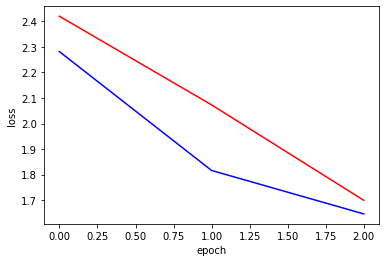

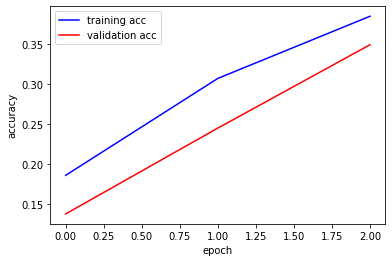

In [45]:
vgg_tiny3 = make_tiny_vgg3(True)

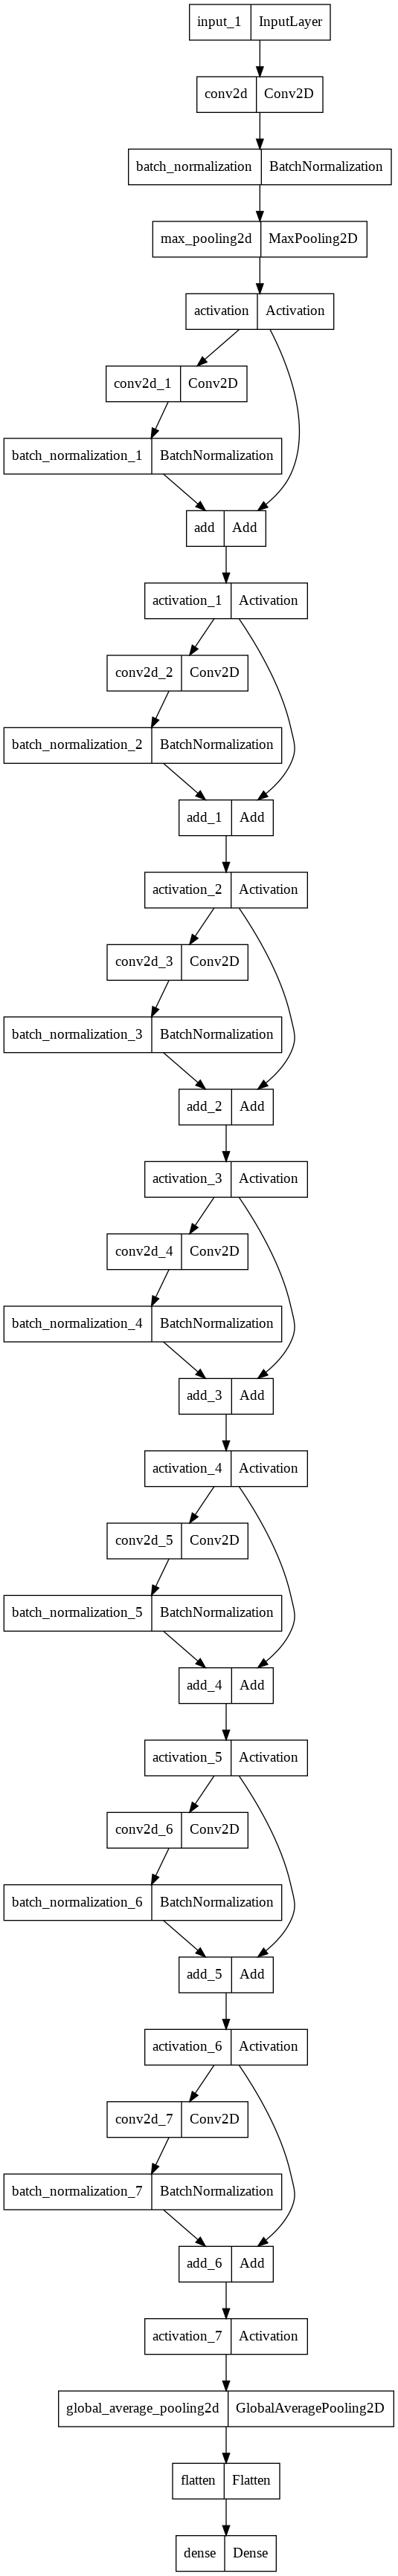

In [39]:
keras.utils.plot_model(vgg_tiny)

In [34]:
losses, accs = [], []
threads = [threading.Thread(target=make_tiny_vgg3, args=(False, losses, accs)) for i in range(5)]
for thread in threads:
  thread.start()
  thread.join()

313/313 [==============================] - 2s 6ms/step - loss: 1.8409 - accuracy: 0.3007


No handles with labels found to put in legend.


[loss] mean: 2.126630997657776, std: 0.7053196409148476
[accuracy] mean: 0.29474000036716463, std: 0.0734902272133379


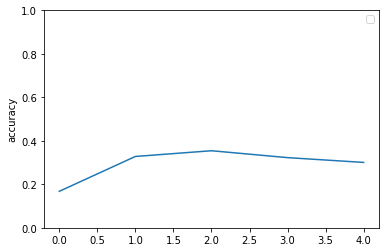

In [35]:
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.plot(accs)
plt.legend();

print(f'[loss] mean: {np.mean(losses)}, std: {statistics.stdev(losses)}')
print(f'[accuracy] mean: {np.mean(accs)}, std: {statistics.stdev(accs)}')